In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
pd.set_option('display.max_columns', None)

## Carregando 

In [44]:
df_regioes = pd.read_csv('bases_analises/df_regioes.csv')

In [45]:
df_regioes = df_regioes.drop(columns = ['pib_ind_pc', 'razao_pib_renda', 'CD_MUN'])

In [46]:
df_regioes

,ano,cod_ibge,emprego_formal,emp_c_sal,massa_rendimentos_num,qtd_formal_Administração_Pública,qtd_formal_Agropecuária,qtd_formal_Alojamento_e_Alimentação,qtd_formal_Artes_e_Cultura,qtd_formal_Atividades_Imobiliárias,qtd_formal_Atividades_Profissionais_e_Técnicas,qtd_formal_Comércio,qtd_formal_Construção,qtd_formal_Educação,qtd_formal_Eletricidade_e_Gás,qtd_formal_Indústria_de_Transformação,qtd_formal_Indústrias_Extrativas,qtd_formal_Informação_e_Comunicação,qtd_formal_Organismos_Internacionais,qtd_formal_Outros_Serviços,qtd_formal_Saneamento_e_Resíduos,qtd_formal_Saúde,qtd_formal_Serviços_Administrativos,qtd_formal_Serviços_Domésticos,qtd_formal_Serviços_Financeiros,qtd_formal_Transporte_e_Correios,qtd_formal_escolaridade_0,qtd_formal_escolaridade_1,qtd_formal_escolaridade_2,qtd_formal_escolaridade_3,qtd_formal_escolaridade_4,ipca_alimentos_bebidas,ipca_artigos_residencia,ipca_comunicacao,ipca_despesas_pessoais,ipca_educacao,ipca_habitacao,ipca_saude_cuidados_pessoais,ipca_transportes,ipca_vestuario,ipca_geral,localidade,pib_agropecuaria,pib_impostos_liq_sub,pib_industria,pib,pib_servicos,pib_servicos_adm_publica,pib_valor_add,n_fam_rua,pes_rf_ate_meio_sm,pes_insc_cadun,perc_rf_ate_meio_sm,Pes_PBF,Fam_PBF,MapSeq,F_CAD_EP,Fam_PBF_Aux,PCD_BPC,Ido_BPC,Pop_65_mais,Pop_2020,65_menos_Idoso_BPC,per_capita_massa_rendimentos,per_capita_pib_agropecuaria,per_capita_pib_industria,per_capita_pib_servicos,per_capita_pib_servicos_adm_publica,per_capita_pib_impostos_liq_sub,per_capita_pib,taxa_qtd_formal_Administração_Pública,taxa_qtd_formal_Agropecuária,taxa_qtd_formal_Alojamento_e_Alimentação,taxa_qtd_formal_Artes_e_Cultura,taxa_qtd_formal_Atividades_Imobiliárias,taxa_qtd_formal_Atividades_Profissionais_e_Técnicas,taxa_qtd_formal_Comércio,taxa_qtd_formal_Construção,taxa_qtd_formal_Educação,taxa_qtd_formal_Eletricidade_e_Gás,taxa_qtd_formal_Indústria_de_Transformação,taxa_qtd_formal_Indústrias_Extrativas,taxa_qtd_formal_Informação_e_Comunicação,taxa_qtd_formal_Organismos_Internacionais,taxa_qtd_formal_Outros_Serviços,taxa_qtd_formal_Saneamento_e_Resíduos,taxa_qtd_formal_Saúde,taxa_qtd_formal_Serviços_Administrativos,taxa_qtd_formal_Serviços_Domésticos,taxa_qtd_formal_Serviços_Financeiros,taxa_qtd_formal_Transporte_e_Correios,taxa_qtd_formal_escolaridade_0,taxa_qtd_formal_escolaridade_1,taxa_qtd_formal_escolaridade_2,taxa_qtd_formal_escolaridade_3,taxa_qtd_formal_escolaridade_4,per_capita_pib_valor_add,perc_n_fam_rua,perc_pes_rf_ate_meio_sm,perc_pes_insc_cadun,perc_Pes_PBF,perc_PCD_BPC,perc_Ido_BPC,perc_Pop_65_mais,perc_65_menos_Idoso_BPC,perc_cadunicoFam_PBF,perc_cadunicoF_CAD_EP,cod_regiao,nome_regiao
0,2018,3500105,10445,9793,21389288.64,996,692,275,20,31,216,2892,362,681,14,1795,0,100,0,390,48,763,753,0,184,233,17,759,1590,6215,1864,4.030782,3.759616,-0.080826,2.989517,5.310920,4.724189,3.951694,4.202469,0.602078,3.745482,Adamantina,35509879,82052356,122889808,1070909946,652715241,177742662,988857590,4,2838,4976,57,943.583333,284.916667,4.0,96.583333,284.916667,391.250000,204.333333,5282,33894,5077.666667,631.064160,1047.674485,3625.709801,19257.545318,5244.074526,2420.851950,31595.856081,0.095357,0.066252,0.026328,0.001915,0.002968,0.020680,0.276879,0.034658,0.065199,0.001340,0.171853,0.000000,0.009574,0.0,0.037338,0.004596,0.073049,0.072092,0.0,0.017616,0.022307,0.001628,0.072666,0.152226,0.595022,0.178459,29175.004131,0.000118,0.083732,0.146811,0.027839,0.011543,0.006029,0.155839,0.149810,0.057258,0.019410,350019,Adamantina - Lucélia
1,2018,3500204,854,828,1628663.10,309,318,2,9,0,2,66,21,0,0,8,32,0,0,54,3,1,18,0,3,8,8,228,168,312,138,4.030782,3.759616,-0.080826,2.989517,5.310920,4.724189,3.951694,4.202469,0.602078,3.745482,Adolfo,22647055,3135155,10942193,92202519,33284014,22194101,89067364,1,1091,1742,"62,6",508.666667,162.583333,3.0,140.000000,162.583333,20.166667,20.583333,521,3447,500.416667,472.487119,6570.076878,3174.410502,9655.936757,6438.671598,909.531477,26748.627502,0.361827,0.372365,0.002342,0.010539,0.000000,0.002342,0.07

## Reamostragem bootstrap por Região

In [47]:
from joblib import Parallel, delayed
from tqdm import tqdm

#Pretendo paralelizar a reamostragem

In [52]:
# =========================================================
# 1. DEFINIÇÃO DAS VARIÁVEIS E PARÂMETROS
# =========================================================

estatisticos = ['media', 'mediana', 'p25', 'p75']
B = 1000 # Número de iterações do bootstrap -> Está levando 1segundo por iteração nos moldes atuais
regiao_col = 'cod_regiao'

# Colunas a serem excluídas da análise estatística (IDs e totais que já têm taxa/per capita)
cols_excluir = [
    # 1. IDENTIFICADORES E CHAVES (Non-Numeric)
    'ano',              # Variável temporal, não é uma métrica estatística de interesse para média/IC.
    'cod_ibge',         # Código único do município (ID).
    'localidade',       # Nome do município (ID de texto).
    'cod_regiao',       # Coluna de agrupamento (não deve ser incluída no cálculo de média/IC).
    'nome_regiao'
    'MapSeq',           # Identificador de mapeamento ou sequência (ID).
    'CD_MUN',           # Código do Município (ID redundante).

    # 2. VARIÁVEIS MACROECONÔMICAS E DE RENDA (VALORES TOTAIS)
    'pib',              # PIB Total. Usaremos 'per_capita_pib'.
    'pib_valor_add',    # Valor Adicionado Total. Usaremos 'per_capita_pib_valor_add'.
    'pib_agropecuaria', # PIB Agropecuária Total. Usaremos 'per_capita_pib_agropecuaria'.
    'pib_industria',    # PIB Indústria Total. Usaremos 'per_capita_pib_industria'.
    'pib_servicos',     # PIB Serviços Total. Usaremos 'per_capita_pib_servicos'.
    'pib_servicos_adm_publica', # PIB Serviços Adm. Pública Total. Usaremos 'per_capita_pib_servicos_adm_publica'.
    'pib_impostos_liq_sub', # PIB Impostos Liq. Sub Total. Usaremos 'per_capita_pib_impostos_liq_sub'.
    'massa_rendimentos_num', # Massa de Rendimentos Total. Usaremos 'per_capita_massa_rendimentos'.

    # 3. VARIÁVEIS DE EMPREGO (CONTADOR ABSOLUTO)
    'emprego_formal',   # Emprego Formal Total.
    'emp_c_sal',        # Emprego com Salário Total.
    # Excluindo todas as contagens absolutas de Emprego por Setor e Escolaridade:
    'qtd_formal_Administração_Pública',
    'qtd_formal_Agropecuária',
    'qtd_formal_Alojamento_e_Alimentação',
    'qtd_formal_Artes_e_Cultura',
    'qtd_formal_Atividades_Imobiliárias',
    'qtd_formal_Atividades_Profissionais_e_Técnicas',
    'qtd_formal_Comércio',
    'qtd_formal_Construção',
    'qtd_formal_Educação',
    'qtd_formal_Eletricidade_e_Gás',
    'qtd_formal_Indústria_de_Transformação',
    'qtd_formal_Indústrias_Extrativas',
    'qtd_formal_Informação_e_Comunicação',
    'qtd_formal_Organismos_Internacionais',
    'qtd_formal_Outros_Serviços',
    'qtd_formal_Saneamento_e_Resíduos',
    'qtd_formal_Saúde',
    'qtd_formal_Serviços_Administrativos',
    'qtd_formal_Serviços_Domésticos',
    'qtd_formal_Serviços_Financeiros',
    'qtd_formal_Transporte_e_Correios',
    'qtd_formal_escolaridade_0',
    'qtd_formal_escolaridade_1',
    'qtd_formal_escolaridade_2',
    'qtd_formal_escolaridade_3',
    'qtd_formal_escolaridade_4',

    # 4. VARIÁVEIS SOCIAIS (CONTADOR ABSOLUTO)
    'Pop_2020',         # População Total 2020.
    'Pop_65_mais',      # População 65+ total. Usaremos 'perc_Pop_65_mais'.
    '65_menos_Idoso_BPC', # Contagem absoluta. Usaremos 'perc_65_menos_Idoso_BPC'.
    'n_fam_rua',        # Famílias em situação de rua (Contagem). Usaremos 'perc_n_fam_rua'.
    'pes_rf_ate_meio_sm', # Pessoas com renda até meio salário mínimo (Contagem). Usaremos 'perc_pes_rf_ate_meio_sm'.
    'pes_insc_cadun',   # Pessoas inscritas no CadÚnico (Contagem). Usaremos 'perc_pes_insc_cadun'.
    'Pes_PBF',          # Pessoas no Bolsa Família (Contagem). Usaremos 'perc_Pes_PBF'.
    'Fam_PBF',          # Famílias no Bolsa Família (Contagem). Usaremos 'perc_cadunicoFam_PBF'.
    'F_CAD_EP',         # Famílias em Extrema Pobreza no CadÚnico (Contagem). Usaremos 'perc_cadunicoF_CAD_EP'.
    'Fam_PBF_Aux',      # Famílias PBF + Auxílio Emergencial (Contagem).
    'PCD_BPC',          # Pessoas com Deficiência no BPC (Contagem). Usaremos 'perc_PCD_BPC'.
    'Ido_BPC',          # Idosos no BPC (Contagem). Usaremos 'perc_Ido_BPC'.
]

# Colunas Alvo (apenas aquelas que queremos tirar a média e IC)
# Usamos o 'set' para garantir exclusão eficiente e a lista final de colunas numéricas
all_numeric_cols = set(df_regioes.select_dtypes(include=np.number).columns.tolist())
cols_to_exclude_set = set(cols_excluir)



# As colunas alvo serão todas as colunas numéricas menos as excluídas
target_cols = list(all_numeric_cols - cols_to_exclude_set)

# Se houver valores NaN que precisem ser tratados (ex: preencher com 0 ou mediana ANTES do bootstrap)
# df[target_cols] = df[target_cols].fillna(df[target_cols].median())

print(f"Total de {len(target_cols)} variáveis a serem analisadas por Bootstrap.")
print(f"Agrupando por {df_regioes[regiao_col].nunique()} Regiões.")

Total de 55 variáveis a serem analisadas por Bootstrap.
Agrupando por 53 Regiões.


In [53]:
resultados_bootstrap = {
    reg: {col: {stat: [] for stat in estatisticos} for col in target_cols}
    for reg in df_regioes[regiao_col].unique()
}

In [56]:
df_regioes.head(1)

,ano,cod_ibge,emprego_formal,emp_c_sal,massa_rendimentos_num,qtd_formal_Administração_Pública,qtd_formal_Agropecuária,qtd_formal_Alojamento_e_Alimentação,qtd_formal_Artes_e_Cultura,qtd_formal_Atividades_Imobiliárias,qtd_formal_Atividades_Profissionais_e_Técnicas,qtd_formal_Comércio,qtd_formal_Construção,qtd_formal_Educação,qtd_formal_Eletricidade_e_Gás,qtd_formal_Indústria_de_Transformação,qtd_formal_Indústrias_Extrativas,qtd_formal_Informação_e_Comunicação,qtd_formal_Organismos_Internacionais,qtd_formal_Outros_Serviços,qtd_formal_Saneamento_e_Resíduos,qtd_formal_Saúde,qtd_formal_Serviços_Administrativos,qtd_formal_Serviços_Domésticos,qtd_formal_Serviços_Financeiros,qtd_formal_Transporte_e_Correios,qtd_formal_escolaridade_0,qtd_formal_escolaridade_1,qtd_formal_escolaridade_2,qtd_formal_escolaridade_3,qtd_formal_escolaridade_4,ipca_alimentos_bebidas,ipca_artigos_residencia,ipca_comunicacao,ipca_despesas_pessoais,ipca_educacao,ipca_habitacao,ipca_saude_cuidados_pessoais,ipca_transportes,ipca_vestuario,ipca_geral,localidade,pib_agropecuaria,pib_impostos_liq_sub,pib_industria,pib,pib_servicos,pib_servicos_adm_publica,pib_valor_add,n_fam_rua,pes_rf_ate_meio_sm,pes_insc_cadun,perc_rf_ate_meio_sm,Pes_PBF,Fam_PBF,MapSeq,F_CAD_EP,Fam_PBF_Aux,PCD_BPC,Ido_BPC,Pop_65_mais,Pop_2020,65_menos_Idoso_BPC,per_capita_massa_rendimentos,per_capita_pib_agropecuaria,per_capita_pib_industria,per_capita_pib_servicos,per_capita_pib_servicos_adm_publica,per_capita_pib_impostos_liq_sub,per_capita_pib,taxa_qtd_formal_Administração_Pública,taxa_qtd_formal_Agropecuária,taxa_qtd_formal_Alojamento_e_Alimentação,taxa_qtd_formal_Artes_e_Cultura,taxa_qtd_formal_Atividades_Imobiliárias,taxa_qtd_formal_Atividades_Profissionais_e_Técnicas,taxa_qtd_formal_Comércio,taxa_qtd_formal_Construção,taxa_qtd_formal_Educação,taxa_qtd_formal_Eletricidade_e_Gás,taxa_qtd_formal_Indústria_de_Transformação,taxa_qtd_formal_Indústrias_Extrativas,taxa_qtd_formal_Informação_e_Comunicação,taxa_qtd_formal_Organismos_Internacionais,taxa_qtd_formal_Outros_Serviços,taxa_qtd_formal_Saneamento_e_Resíduos,taxa_qtd_formal_Saúde,taxa_qtd_formal_Serviços_Administrativos,taxa_qtd_formal_Serviços_Domésticos,taxa_qtd_formal_Serviços_Financeiros,taxa_qtd_formal_Transporte_e_Correios,taxa_qtd_formal_escolaridade_0,taxa_qtd_formal_escolaridade_1,taxa_qtd_formal_escolaridade_2,taxa_qtd_formal_escolaridade_3,taxa_qtd_formal_escolaridade_4,per_capita_pib_valor_add,perc_n_fam_rua,perc_pes_rf_ate_meio_sm,perc_pes_insc_cadun,perc_Pes_PBF,perc_PCD_BPC,perc_Ido_BPC,perc_Pop_65_mais,perc_65_menos_Idoso_BPC,perc_cadunicoFam_PBF,perc_cadunicoF_CAD_EP,cod_regiao,nome_regiao
0,2018,3500105,10445,9793,21389288.64,996,692,275,20,31,216,2892,362,681,14,1795,0,100,0,390,48,763,753,0,184,233,17,759,1590,6215,1864,4.030782,3.759616,-0.080826,2.989517,5.31092,4.724189,3.951694,4.202469,0.602078,3.745482,Adamantina,35509879,82052356,122889808,1070909946,652715241,177742662,988857590,4,2838,4976,57,943.583333,284.916667,4.0,96.583333,284.916667,391.25,204.333333,5282,33894,5077.666667,631.06416,1047.674485,3625.709801,19257.545318,5244.074526,2420.85195,31595.856081,0.095357,0.066252,0.026328,0.001915,0.002968,0.02068,0.276879,0.034658,0.065199,0.00134,0.171853,0.0,0.009574,0.0,0.037338,0.004596,0.073049,0.072092,0.0,0.017616,0.022307,0.001628,0.072666,0.152226,0.595022,0.178459,29175.004131,0.000118,0.083732,0.146811,0.027839,0.011543,0.006029,0.155839,0.14981,0.057258,0.01941,350019,Adamantina - Lucélia


In [57]:
grouped = df_regioes.groupby(['cod_regiao','nome_regiao'])
regions = list(grouped.groups.keys())

In [60]:
###Uma interação da reamostragem. Está definida assim para ser paralelizada.

def bootstrap_iteration(seed=None):
    np.random.seed(seed)
    results = {}

    for regiao, df_regiao in grouped:
        sample = df_regiao.sample(n=len(df_regiao), replace=True)
        results[regiao] = {}

        data = sample[target_cols].values  # convert to numpy array for speed

        for i, col in enumerate(target_cols):
            col_data = data[:, i]
            col_data = col_data[~np.isnan(col_data)]  # remover NaNs
            results[regiao][col] = {
                'media': col_data.mean(),
                'mediana': np.median(col_data),
                'p25': np.percentile(col_data, 25),
                'p75': np.percentile(col_data, 75)
            }
    return results


In [62]:
results_list = Parallel(n_jobs=-1)(
    delayed(bootstrap_iteration)(seed=i) for i in tqdm(range(B))
)



  2%|▏         | 15/1000 [27:33:07<1809:15:13, 6612.50s/it]




























































































































100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


In [ ]:
# Flatten results into a DataFrame for easier analysis
rows = []
for iteration, result in enumerate(results_list):
    for regiao, cols in result.items():
        cod_regiao, nome_regiao = regiao  # desempacota a tupla
        for col, stats in cols.items():
            row = {
                'iteration': iteration,
                'cod_regiao': cod_regiao,
                'nome_regiao': nome_regiao,
                'coluna': col,
                **stats
            }
            rows.append(row)

df_bootstrap = pd.DataFrame(rows)

In [68]:
df_bootstrap

,iteration,cod_regiao,nome_regiao,coluna,media,mediana,p25,p75
0,0,350001,São Paulo,perc_Pop_65_mais,0.083610,0.080264,0.073354,0.091379
1,0,350001,São Paulo,taxa_qtd_formal_Agropecuária,0.016456,0.000821,0.000097,0.009307
2,0,350001,São Paulo,taxa_qtd_formal_Indústria_de_Transformação,0.242870,0.243470,0.154459,0.345938
3,0,350001,São Paulo,ipca_alimentos_bebidas,8.017033,6.364091,4.030782,14.113456
4,0,350001,São Paulo,taxa_qtd_formal_Saúde,0.034279,0.029548,0.016074,0.047254
...,...,...,...,...,...,...,...,...
2914995,999,350053,Cruzeiro,ipca_habitacao,4.917668,5.274873,4.724189,5.274873
2914996,999,350053,Cruzeiro,ipca_educacao,3.084060,1.134802,1.134802,5.310920
2914997,999,350053,Cruzeiro,taxa_qtd_formal_Administração_Pública,0.457464,0.493047,0.378039,0.541339
2914998,999,350053,Cruzeiro,ipca_saude_cuidados_pessoais,2.843170,1.501329,1.501329,3.951694


In [69]:
print(df_bootstrap.shape)
print(df_bootstrap.head())
print(df_bootstrap.info())



(2915000, 8)
   iteration  cod_regiao nome_regiao  \
0          0      350001   São Paulo   
1          0      350001   São Paulo   
2          0      350001   São Paulo   
3          0      350001   São Paulo   
4          0      350001   São Paulo   

                                       coluna     media   mediana       p25  \
0                            perc_Pop_65_mais  0.083610  0.080264  0.073354   
1                taxa_qtd_formal_Agropecuária  0.016456  0.000821  0.000097   
2  taxa_qtd_formal_Indústria_de_Transformação  0.242870  0.243470  0.154459   
3                      ipca_alimentos_bebidas  8.017033  6.364091  4.030782   
4                       taxa_qtd_formal_Saúde  0.034279  0.029548  0.016074   

         p75  
0   0.091379  
1   0.009307  
2   0.345938  
3  14.113456  
4   0.047254  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915000 entries, 0 to 2914999
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   iteration   

In [71]:
summary = df_bootstrap.groupby(['cod_regiao', 'nome_regiao','coluna']).agg(
media_mean=('media', 'mean'),
media_std=('media', 'std'),
mediana_mean=('mediana', 'mean'),
mediana_std=('mediana', 'std'),
p25_mean=('p25', 'mean'),
p75_mean=('p75', 'mean'),
lower_ci=('media', lambda x: np.percentile(x, 2.5)),
upper_ci=('media', lambda x: np.percentile(x, 97.5))
).reset_index()

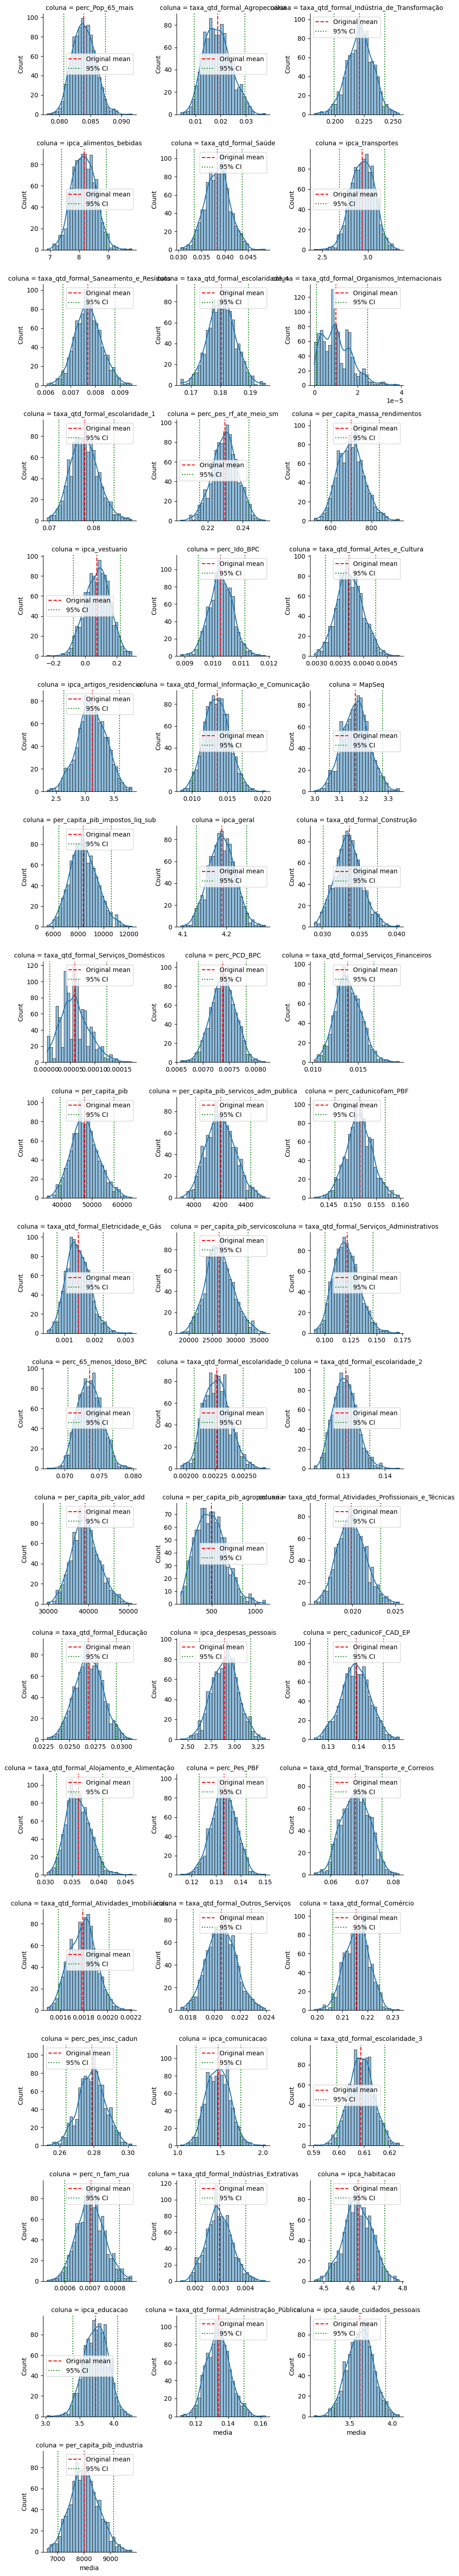

In [ ]:
# exemplo para UMA região
region_example = df_bootstrap['cod_regiao'].unique()[0]

subset = df_bootstrap.query("cod_regiao == @region_example")
original_region = df_regioes.query("cod_regiao == @region_example")

g = sns.FacetGrid(subset, col="coluna", col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, "media", bins=30, kde=True)
for ax, col in zip(g.axes.flat, target_cols):
    orig_value = original_region[col].mean() if col in original_region.columns else None
    if orig_value is not None:
        ax.axvline(orig_value, color='red', linestyle='--', label='Original mean')

    # 95% CI from bootstrap
    boot_data = subset.query("coluna == @col")['media']
    lower_ci, upper_ci = np.percentile(boot_data, [2.5, 97.5])
    ax.axvline(lower_ci, color='green', linestyle=':', label='95% CI')
    ax.axvline(upper_ci, color='green', linestyle=':')
    ax.legend()

plt.tight_layout()
plt.show()

## Fazer distribuição media,mediana,p25,p75 de todo df_bootstrap

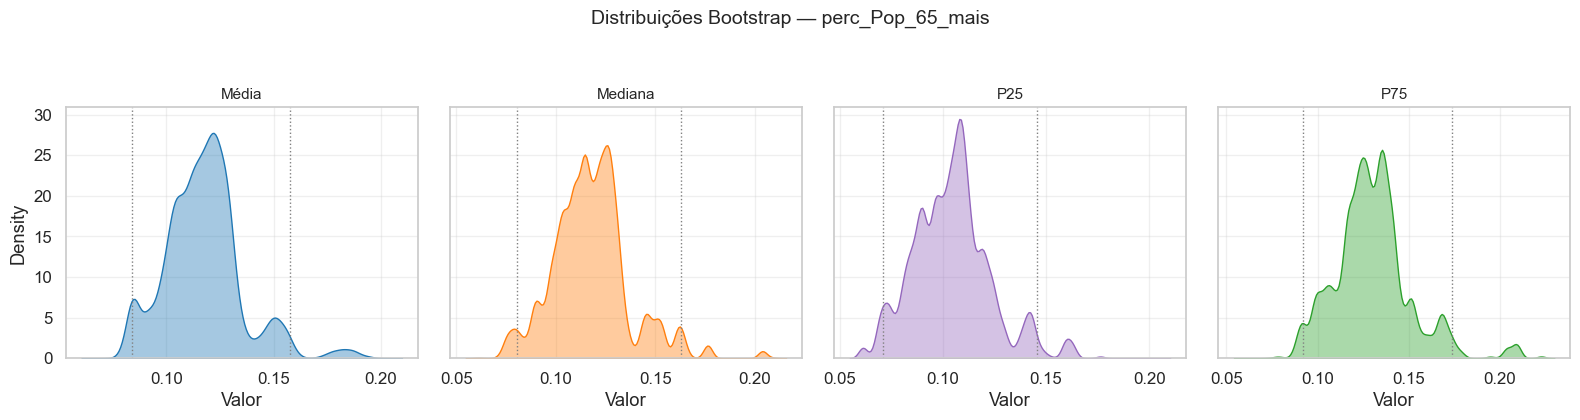

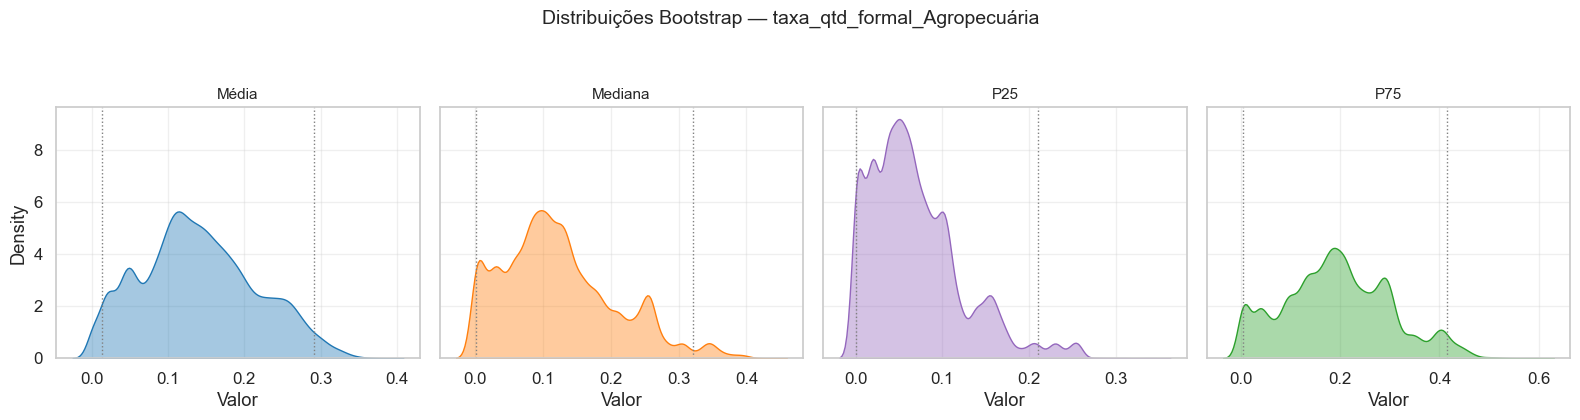

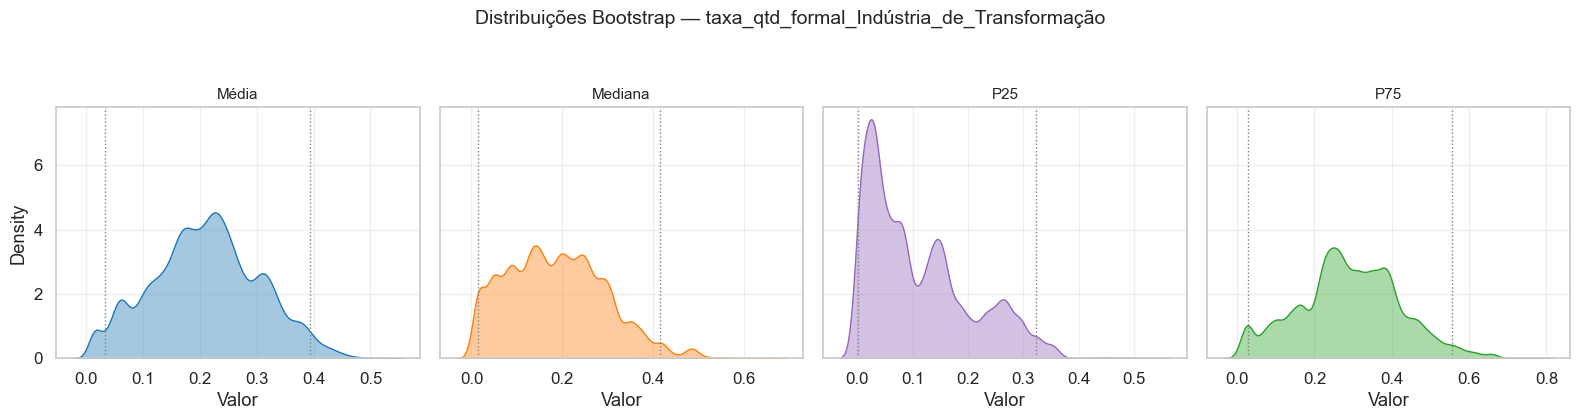

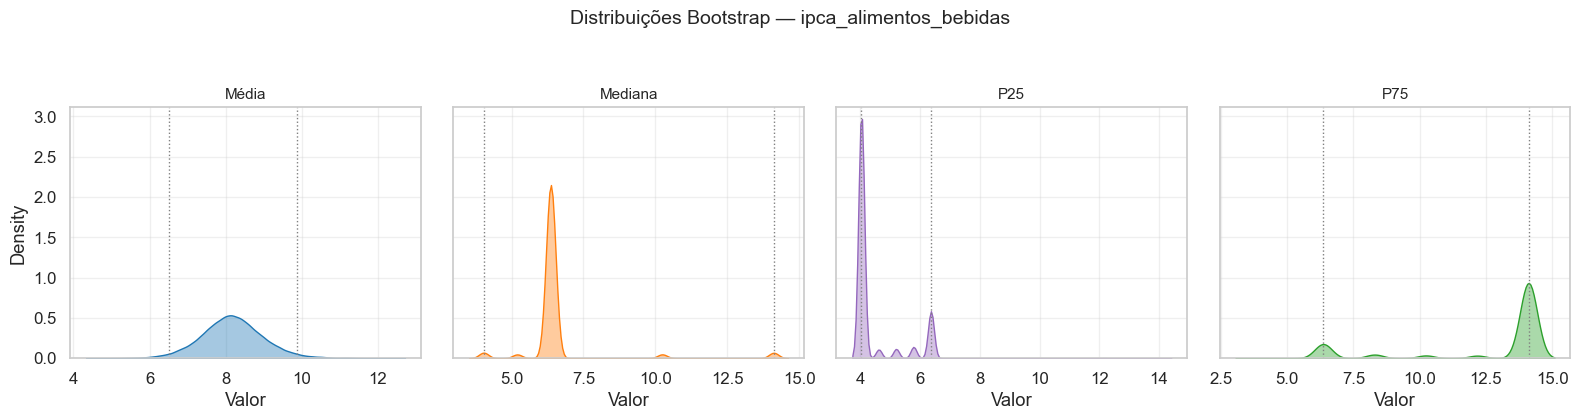

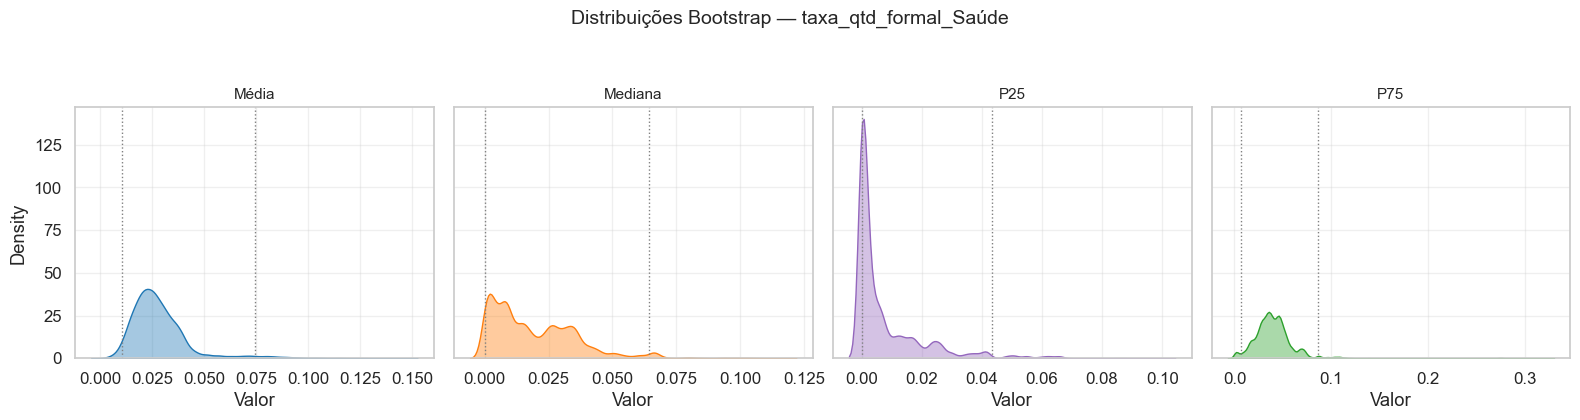

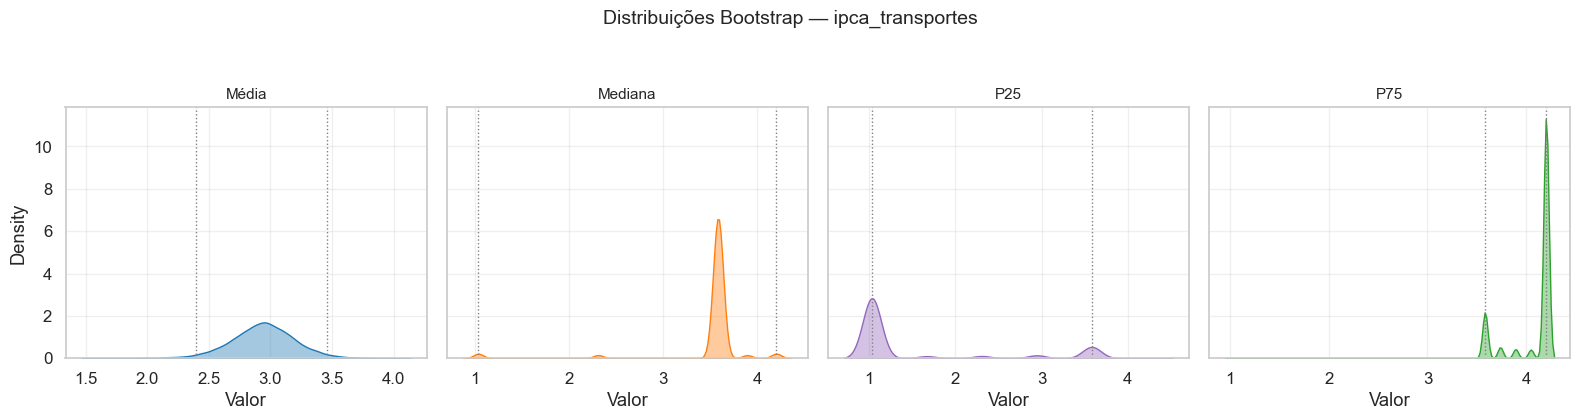

In [94]:
sns.set_theme(style="whitegrid", font_scale=1.1)

# Exemplo: primeiras 6 variáveis
cols_plot = df_bootstrap['coluna'].unique()[:6]

for col in cols_plot:
    df_col = df_bootstrap[df_bootstrap['coluna'] == col]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    fig.suptitle(f"Distribuições Bootstrap — {col}", fontsize=14, y=1.05)

    metrics = ['media', 'mediana', 'p25', 'p75']
    titles = ['Média', 'Mediana', 'P25', 'P75']
    colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#2ca02c']

    for ax, metric, title, color in zip(axes, metrics, titles, colors):
        sns.kdeplot(df_col[metric], fill=True, alpha=0.4, color=color, ax=ax)

        # Intervalo de confiança 95%
        lower_ci, upper_ci = np.percentile(df_col[metric], [2.5, 97.5])
        ax.axvline(lower_ci, color='gray', linestyle=':', linewidth=1)
        ax.axvline(upper_ci, color='gray', linestyle=':', linewidth=1)

        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Valor')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## Fazer as distribuições media,mediana,p25,p75 para algumas regiões

pegar uma região com muito municipios , outras com pouco,...

## Criar o summary

escolhido após as distribuições das colunas do bootstrap

In [ ]:
# =========================================================
# 5. SUMÁRIO FINAL DO BOOTSTRAP (agregado por região e coluna)
# =========================================================

summary_bootstrap = (
    df_bootstrap
    .groupby(['cod_regiao', 'nome_regiao', 'coluna'])
    .agg(
        # Média das médias e desvio-padrão
        media_mean=('media', 'mean'),
        media_std=('media', 'std'),

        # Média das medianas e desvio-padrão
        mediana_mean=('mediana', 'mean'),
        mediana_std=('mediana', 'std'),

        # Novo: Mediana da mediana, P25 da mediana e P75 da mediana
        mediana_mediana=('mediana', 'median'),
        p25_mediana=('mediana', lambda x: np.percentile(x, 25)),
        p75_mediana=('mediana', lambda x: np.percentile(x, 75)),

        # Intervalos de confiança para média (se quiser manter)
        lower_ci=('media', lambda x: np.percentile(x, 2.5)),
        upper_ci=('media', lambda x: np.percentile(x, 97.5))
    )
    .reset_index()
)

print(summary_bootstrap.head())


In [ ]:
df_bootstrap.to_csv('bases_analises/df_bootstrap_regioes.csv', index=False)

In [78]:
summary.to_excel('bases_analises/summary_bootstrap_regioes.xlsx', index=False)

In [ ]:
# ver as caudas de p25 e p75 para ver a dispersão nas extremidades
# como esses dados são distribuidos -> coeficiente de correlação espaciais entre regiões
# mapa de calor por variável e dps de correlação dois a dois - multinformation (eu acho q é correlação multipla). tentar ver essas coisas espaciais
# utilizar o pySAL para fazer essas análises espaciais

